In [170]:
import struct
import math
import numpy as np
import intvalpy as ip
import matplotlib.pyplot as plt
import seaborn as sns
from functools import cmp_to_key
from scipy.stats import zscore
from pathlib import Path

In [171]:
def read_bin_file_with_numpy(file_path):
  with open(file_path, 'rb') as f:
    header_data = f.read(256)
    side, mode, frame_count = struct.unpack('<BBH', header_data[:4])

    frames = []
    point_dtype = np.dtype('<8H')

    for _ in range(frame_count):
      frame_header_data = f.read(16)
      stop_point, timestamp = struct.unpack('<HL', frame_header_data[:6])
      frame_data = np.frombuffer(f.read(1024 * 16), dtype=point_dtype)
      frames.append(frame_data)

    return np.array(frames)

In [172]:
def convert_to_voltage(data):
  return data / 16384.0 - 0.5

In [173]:
def are_intersected(x, y):
  sup = y.a if x.a < y.a else x.a
  inf = x.b if x.b < y.b else y.b
  return sup - inf <= 1e-15

In [174]:
def are_adjusted_to_each_other(x, y):
  return x.b == y.a or y.b == x.a

In [175]:
def merge_intervals(x, y):
  return ip.Interval(min(x.a, y.a), max(x.b, y.b))

In [176]:
def mode(x):
  if len(x) == 0:
    return []

  edges = sorted({x_i.a for x_i in x}.union({x_i.b for x_i in x}))
  z = [ip.Interval(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
  mu = [sum(1 for x_i in x if z_i in x_i) for z_i in z]

  max_mu = max(mu)
  K = [index for index, element in enumerate(mu) if element == max_mu]

  m = [z[k] for k in K]
  merged_m = []

  current_interval = m[0]

  for next_interval in m[1:]:
    if are_intersected(current_interval, next_interval) or are_adjusted_to_each_other(current_interval, next_interval):
      current_interval = merge_intervals(current_interval, next_interval)
    else:
      merged_m.append(current_interval)
      current_interval = next_interval

  merged_m.append(current_interval)

  return merged_m

In [177]:
def med_k(x):
  starts = [float(interval.a) for interval in x]
  ends = [float(interval.b) for interval in x]
  return ip.Interval(np.median(starts), np.median(ends))

In [178]:
def med_p(x):
  x = sorted(x, key=cmp_to_key(lambda x, y: (x.a + x.b) / 2 - (y.a + y.b) / 2))

  mid_index = len(x) // 2

  if len(x) % 2 == 0:
    return (x[mid_index - 1] + x[mid_index]) / 2

  return x[mid_index]

In [179]:
def jaccard_index(*args):
  if len(args) == 1:
    x = args[0]
    left_edges = [interval.a for interval in x]
    right_edges = [interval.b for interval in x]

    return (min(right_edges) - max(left_edges)) / (max(right_edges) - min(left_edges))
  elif len(args) == 2:
    x = args[0]
    y = args[1]

    if isinstance(x, ip.ClassicalArithmetic) and isinstance(y, ip.ClassicalArithmetic):
      return (min(x.b, y.b) - max(x.a, y.a)) / (max(x.b, y.b) - min(x.a, y.a))
    else:
      results = []

      for x_i, y_i in zip(x, y):
        result = (min(x_i.b, y_i.b) - max(x_i.a, y_i.a)) / (max(x_i.b, y_i.b) - min(x_i.a, y_i.a))
        results.append(result)

      return np.array(results)
  else:
    raise ValueError("Wrong number of arguments")

In [180]:
def scalar_to_interval(x, rad):
  return ip.Interval(x - rad, x + rad)
scalar_to_interval_vec = np.vectorize(scalar_to_interval)

In [181]:
x_data = read_bin_file_with_numpy('-0.205_lvl_side_a_fast_data.bin')
y_data = read_bin_file_with_numpy('0.225_lvl_side_a_fast_data.bin')

In [182]:
files = [Path('-0.205_lvl_side_a_fast_data.bin'), Path('0.225_lvl_side_a_fast_data.bin')]

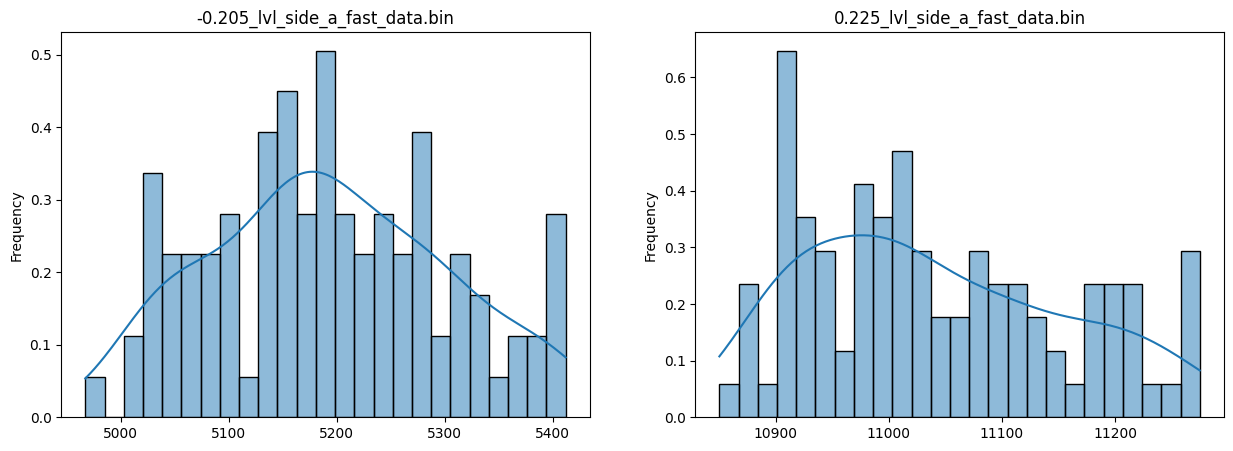

In [183]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

for index, file_path in enumerate(files):
  frames = read_bin_file_with_numpy(file_path)
  ys = []

  for frame in frames:
    px = frame.flatten()[0]
    ys.append(px)

  axis = axes[index]
  sns.histplot(ys, ax=axis, bins=25, stat='frequency', kde=True)
  axis.set_title(file_path)

In [184]:
x_voltage = convert_to_voltage(x_data)
y_voltage = convert_to_voltage(y_data)

x_voltage = np.transpose(x_voltage, axes=(2, 1, 0))
y_voltage = np.transpose(y_voltage, axes=(2, 1,0))

<Axes: ylabel='Count'>

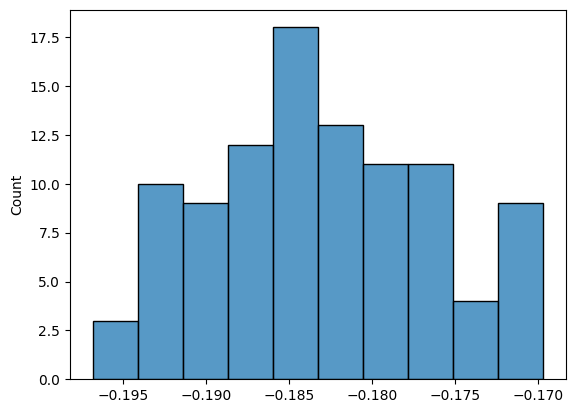

In [185]:
sns.histplot(x_voltage[0,0,:], bins=10)

<Axes: ylabel='Count'>

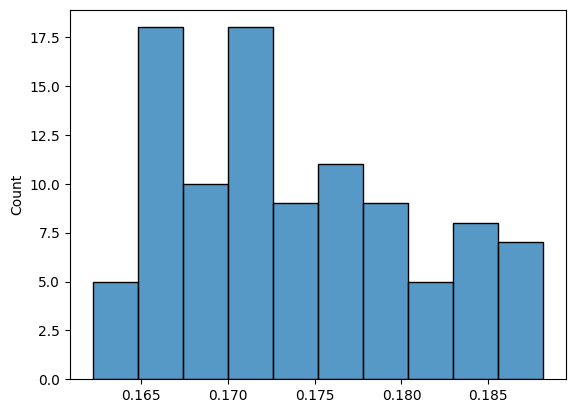

In [186]:
sns.histplot(y_voltage[0,0,:], bins=10)

In [187]:
x_voltage = np.mean(x_voltage, axis=2)
y_voltage = np.mean(y_voltage, axis=2)

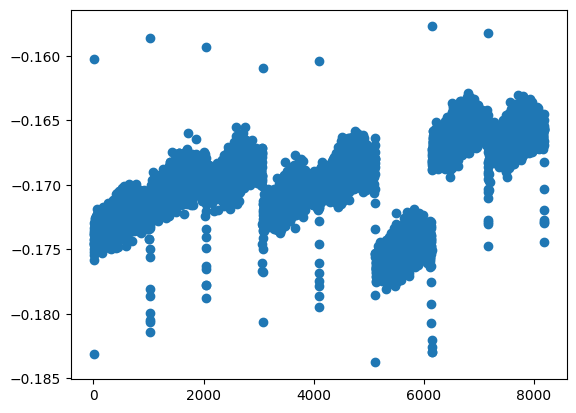

In [188]:
plt.scatter(list(range(1, x_voltage.flatten().shape[0]  + 1)), x_voltage.flatten())

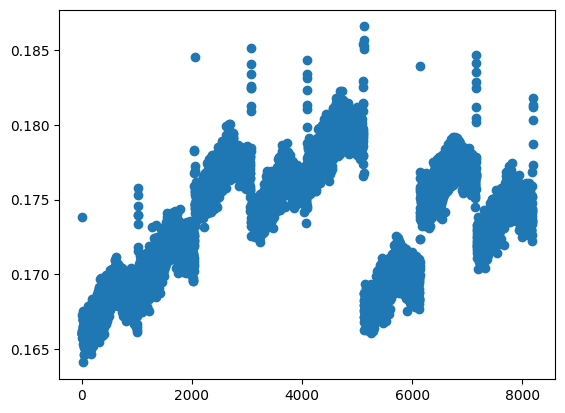

In [189]:
plt.scatter(list(range(1, y_voltage.flatten().shape[0]  + 1)), y_voltage.flatten())

In [190]:
x_voltage = x_voltage[2].flatten()
y_voltage = y_voltage[2].flatten()

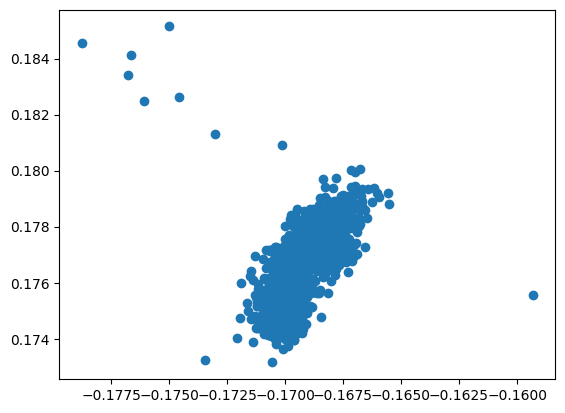

In [191]:
plt.scatter(x_voltage, y_voltage)

In [192]:
z_scores_x = zscore(x_voltage)
z_scores_y = zscore(y_voltage)

threshold = 3

non_outlier_indices = np.where((np.abs(z_scores_x) < threshold) & (np.abs(z_scores_y) < threshold))

# Filter the arrays to remove outliers
x_voltage = x_voltage[non_outlier_indices]
y_voltage = y_voltage[non_outlier_indices]

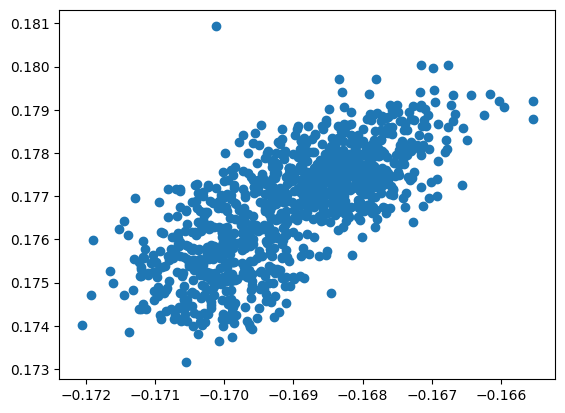

In [193]:
plt.scatter(x_voltage, y_voltage)

In [194]:
x_voltage_flatten = x_voltage_flatten[:10000]
y_voltage_flatten = y_voltage_flatten[:10000]

In [195]:
rad = 2 ** -14
x_voltage_int_flatten = scalar_to_interval_vec(x_voltage_flatten, rad)
y_voltage_int_flatten = scalar_to_interval_vec(y_voltage_flatten, rad)

In [196]:
def ternary_search(f, left, right, eps):
  while right - left > eps:
    m1 = left + (right - left) / 3
    m2 = right - (right - left) / 3

    if f(m1) < f(m2):
      left = m1
    else:
      right = m2

  return (left + right) / 2

In [197]:
def estimate_a(a):
  return np.mean(jaccard_index(x_voltage_int_flatten + a, y_voltage_int_flatten))

def estimate_t(t):
  return np.mean(jaccard_index(x_voltage_int_flatten * t, y_voltage_int_flatten))

def estimate_a_mode(a):
  return np.mean(jaccard_index(mode(x_voltage_int_flatten + a), mode(y_voltage_int_flatten)))

def estimate_t_mode(t):
  x = mode(x_voltage_int_flatten * t)
  x_idx = len(x) // 2
  x = x[x_idx]

  y = mode(y_voltage_int_flatten)
  y_idx = len(y) // 2
  y = y[y_idx]

  return np.mean(jaccard_index(x, y))

def estimate_a_med_p(a):
  return np.mean(jaccard_index(med_p(x_voltage_int_flatten + a), med_p(y_voltage_int_flatten)))

def estimate_t_med_p(t):
  return np.mean(jaccard_index(med_p(x_voltage_int_flatten * t), med_p(y_voltage_int_flatten)))

def estimate_a_med_k(a):
  return np.mean(jaccard_index(med_k(x_voltage_int_flatten + a), med_k(y_voltage_int_flatten)))

def estimate_t_med_k(t):
  return np.mean(jaccard_index(med_k(x_voltage_int_flatten * t), med_k(y_voltage_int_flatten)))

In [198]:
a_1 = ternary_search(estimate_a, 0, 1, 1e-3)
a_1, estimate_a(a_1)

(0.3460108636639504, mpf('-0.811797194724327915869021011436328009554'))

In [199]:
t_1 = ternary_search(estimate_t, -4, 0, 1e-3)
t_1, estimate_t(t_1)

(-1.0503764584974888, mpf('-0.860740231413447431407033143883330395584'))

In [200]:
a_2 = ternary_search(estimate_a_mode, -4, 4, 1e-3)
a_2, estimate_a_mode(a_2)

(0.3467468443145223, mpf('-0.986299975232709539415213545283515987522'))

In [201]:
t_2 = ternary_search(estimate_t_mode, -4, 0, 1e-3)
t_2, estimate_t_mode(t_2)

(-1.0394738453842631, mpf('-0.886605167029676852617977821804127236334'))

In [202]:
a_3 = ternary_search(estimate_a_med_p, -4, 4, 1e-3)
a_3, estimate_a_med_p(a_3)

(0.3440580734109482, mpf('-0.017808418816220278128955398217856999299'))

In [203]:
t_3 = ternary_search(estimate_t_med_p, -4, 0, 1e-3)
t_3, estimate_t_med_p(t_3)

(-1.0277284186653293, mpf('0.845726510388663164047600918699001124744'))

In [204]:
a_4 = ternary_search(estimate_a_med_k, -4, 4, 1e-3)
a_4, estimate_a_med_k(a_4)

(0.3440580734109482, mpf('-0.0178084188162368337802692163315892917542'))

In [205]:
t_4 = ternary_search(estimate_t_med_k, -4, 0, 1e-3)
t_4, estimate_t_med_k(t_4)

(-1.0277284186653293, mpf('0.845726510388706166937378121375658163467'))